# Proyecto: Detectando Críticas Negativas en Reseñas de Películas 

## Descripción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

In [2]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

d:\anaconda\envs\nuevo_entorno\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')  



In [4]:
# esto es para usar progress_apply
tqdm.pandas()

## Cargar datos

In [5]:
df_reviews = pd.read_csv("C:\\Users\\MIKE PC\\Downloads\\imdb_reviews.tsv", sep='\t', dtype={'votes': 'Int64'})

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

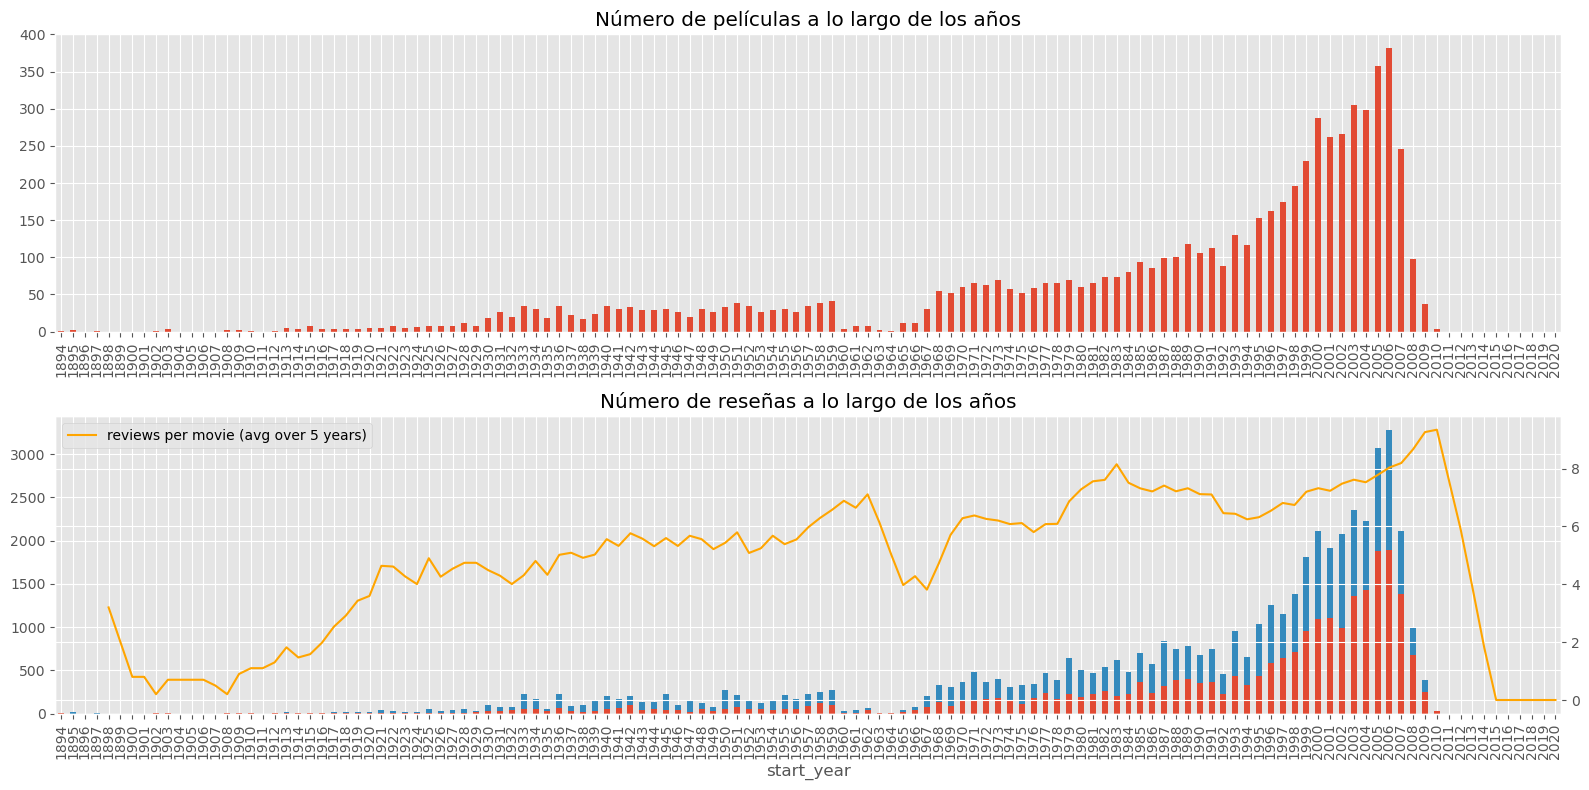

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

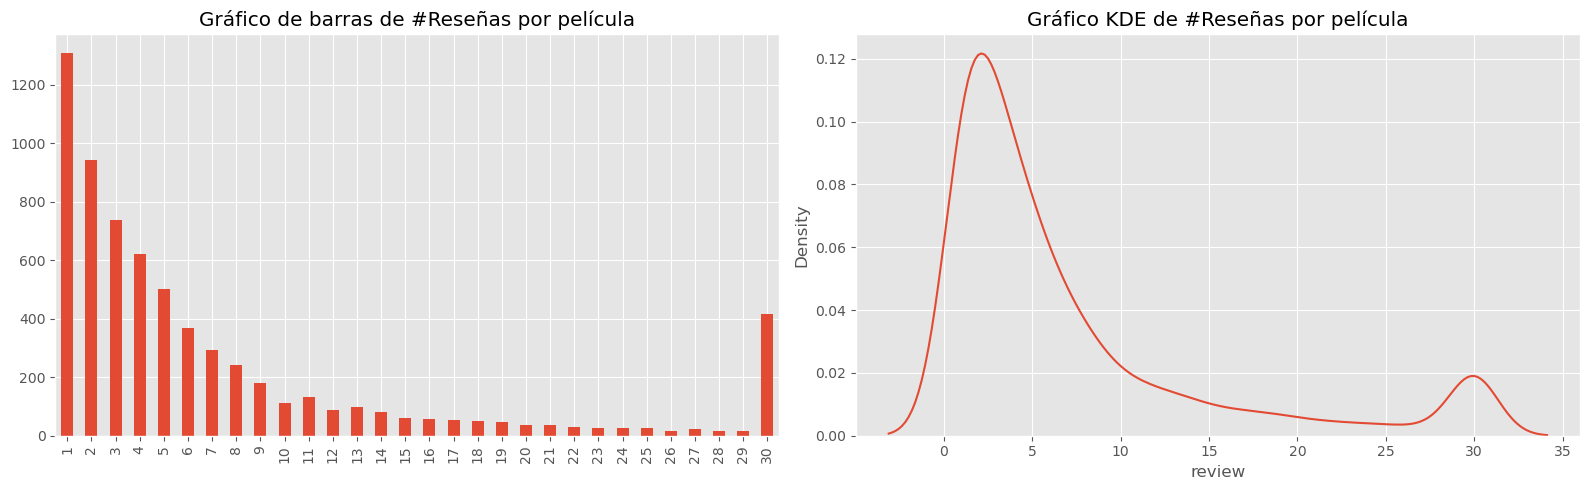

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [8]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

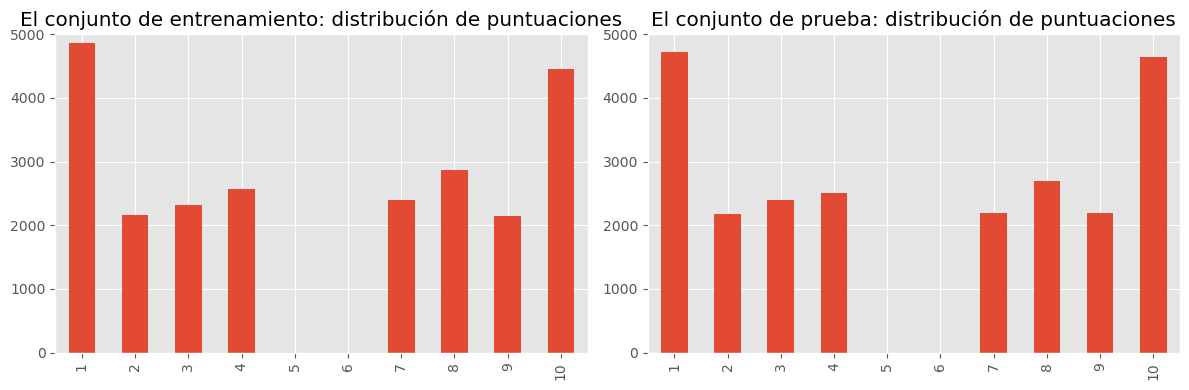

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

C:\Users\MIKE PC\AppData\Local\Temp\ipykernel_18284\1324160450.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\MIKE PC\AppData\Local\Temp\ipykernel_18284\1324160450.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
C:\Users\MIKE PC\AppData\Local\Temp\ipykernel_18284\1324160450.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\MIKE PC\AppData\Local\Temp\ipykernel_18284\1324160450.py:31: UserWarning: 

Suppo

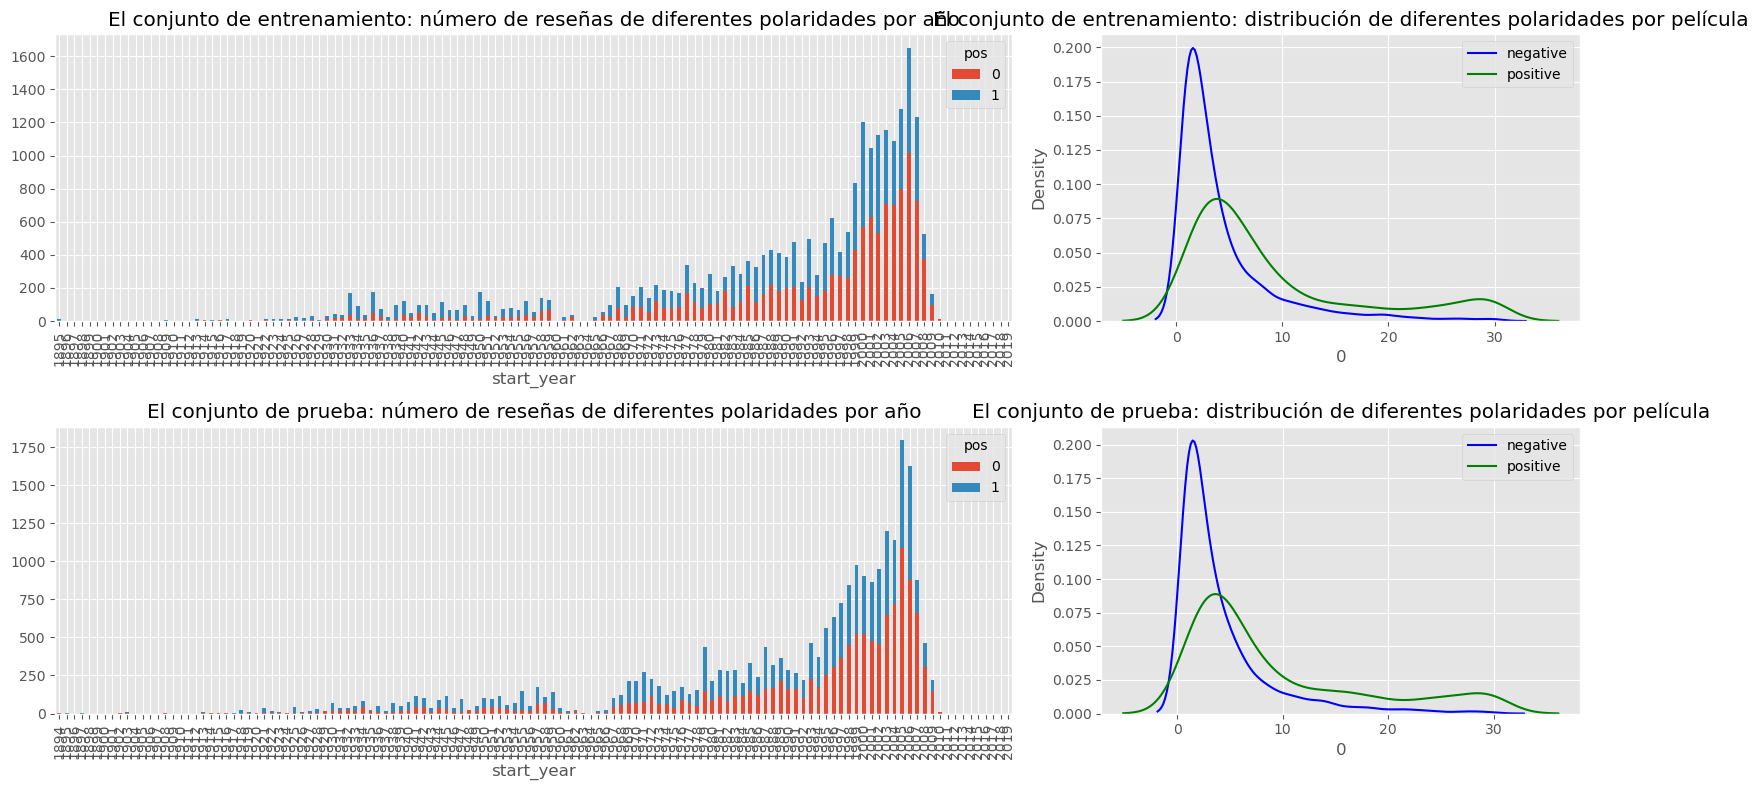

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [11]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [12]:
import re

def normalize_text(text):
    text = text.lower()  
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [13]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [14]:
from sklearn.dummy import DummyClassifier

In [15]:
model_0 = DummyClassifier(strategy='most_frequent', random_state=42)

In [16]:
train_features_0 = df_reviews_train['review_norm']
test_features_0 = df_reviews_test['review_norm']

           train  test
Exactitud    NaN   NaN
F1           0.0   0.0
APS          0.5   0.5
ROC AUC      0.5   0.5


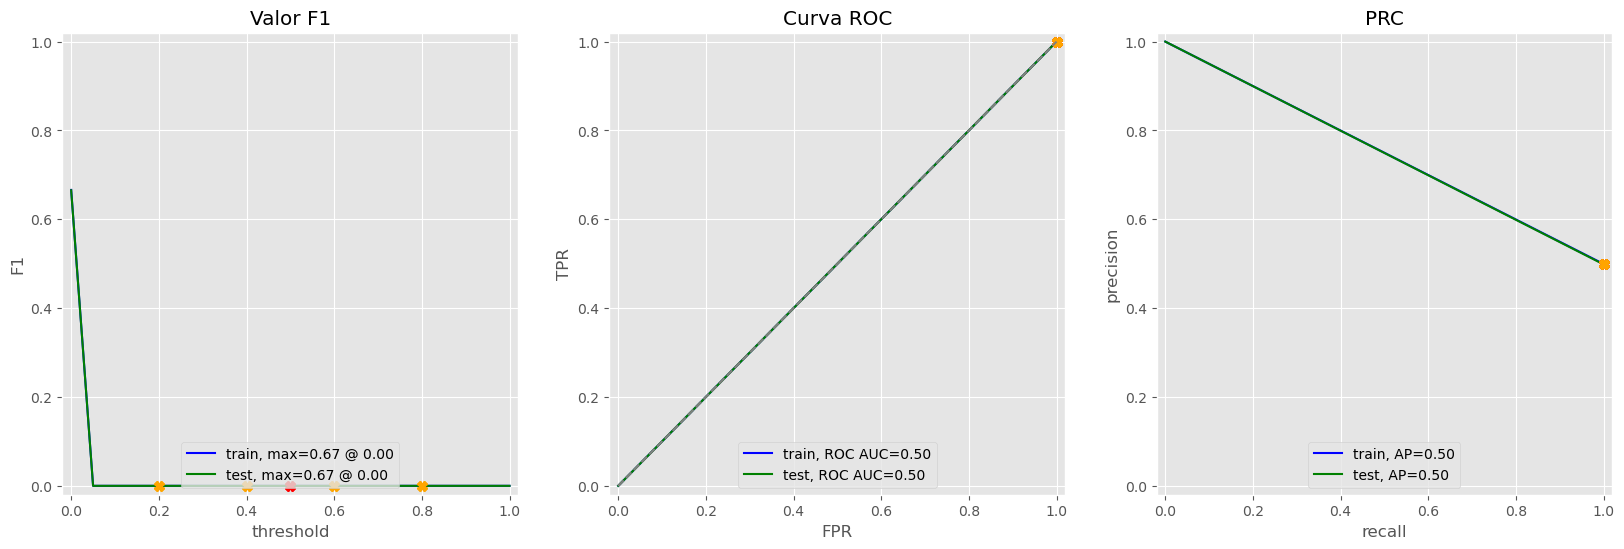

In [17]:
model_0.fit(train_features_0.values.reshape(-1, 1), train_target)

evaluate_model(model_0, train_features_0.values.reshape(-1, 1), train_target, test_features_0.values.reshape(-1, 1), test_target)


### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [18]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [19]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)

train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

model_1 = LogisticRegression(random_state=42, max_iter=1000)


[nltk_data] Downloading package stopwords to C:\Users\MIKE
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
model_1.fit(train_features_1, train_target)


LogisticRegression(max_iter=1000, random_state=42)

           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


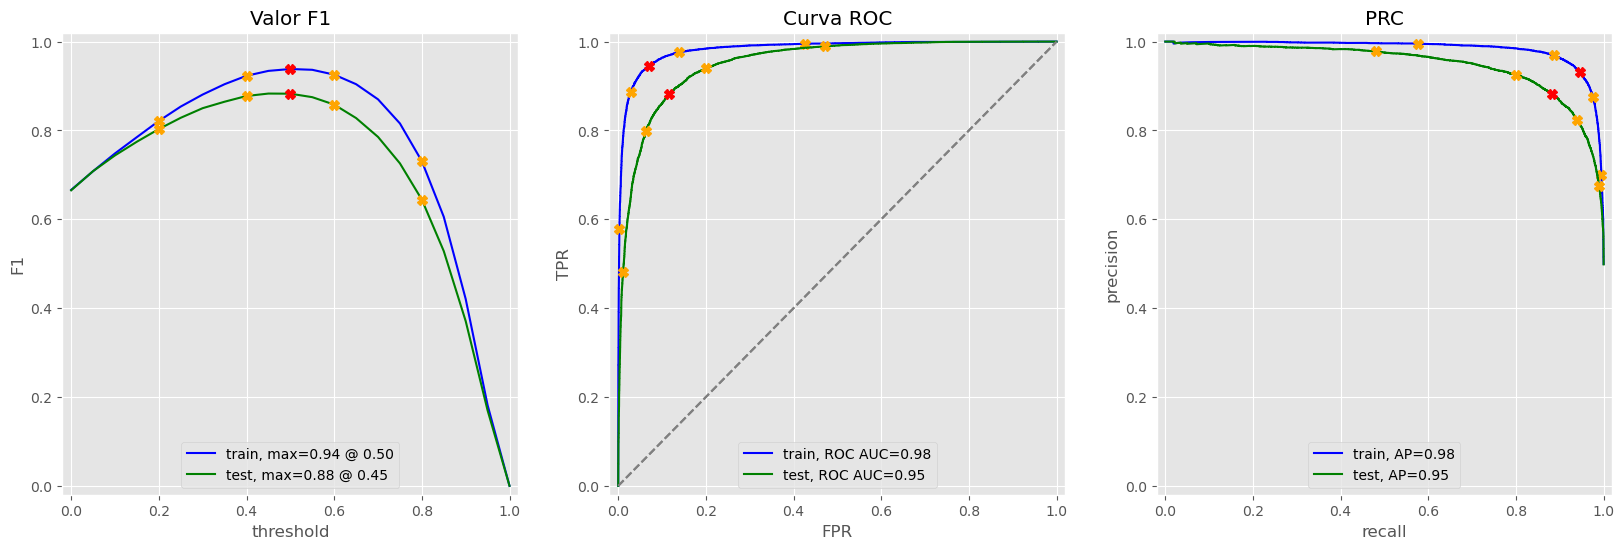

In [21]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Modelo 3 - spaCy, TF-IDF y LR

In [22]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [23]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [24]:
import torch
print(torch.cuda.is_available())


True


In [25]:
train_features_3 = df_reviews_train['review_norm'].apply(text_preprocessing_3)
test_features_3 = df_reviews_test['review_norm'].apply(text_preprocessing_3)

tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)

train_features_3 = tfidf_vectorizer_3.fit_transform(train_features_3)
test_features_3 = tfidf_vectorizer_3.transform(test_features_3)


In [26]:
model_3 = LogisticRegression(random_state=42, max_iter=1000)

model_3.fit(train_features_3, train_target)

LogisticRegression(max_iter=1000, random_state=42)

           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


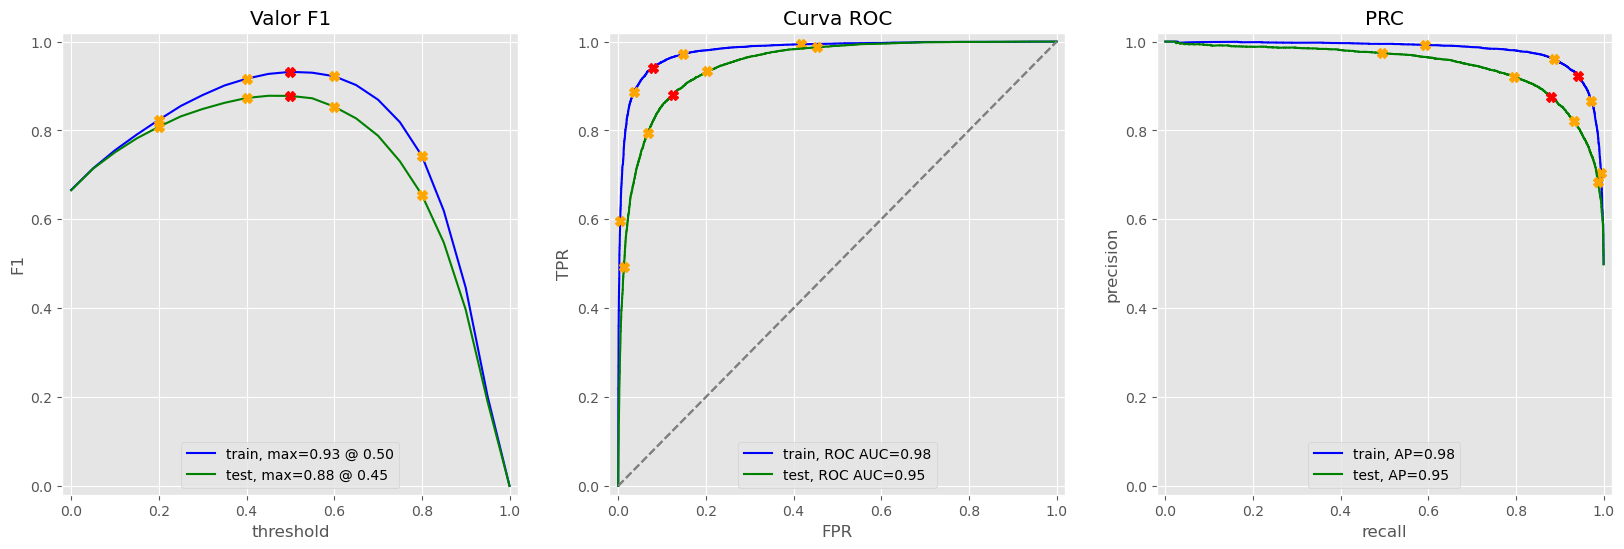

In [27]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [28]:
from lightgbm import LGBMClassifier

In [29]:
model_4 = LGBMClassifier(random_state=42)

model_4.fit(train_features_3, train_target)


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.281689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 445896
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9344
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


LGBMClassifier(random_state=42)

           train  test
Exactitud    NaN   NaN
F1          0.91  0.86
APS         0.97  0.93
ROC AUC     0.97  0.93


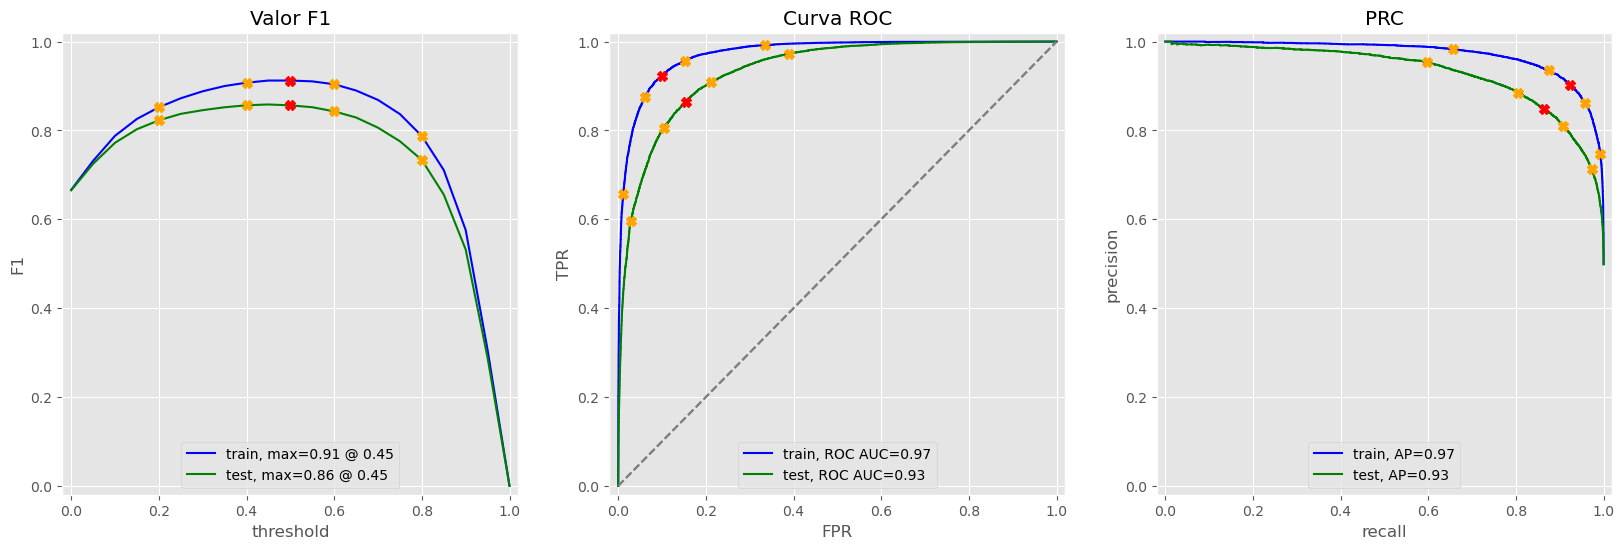

In [30]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

###  Modelo 9 - BERT

In [31]:
import torch
import transformers

In [32]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [33]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []
    
    # Preprocesar los textos con BERT
    for text in texts:
        ids = tokenizer.encode(text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded_ids = ids + [0] * (max_length - len(ids))
        ids_list.append(padded_ids)
        attention_mask = [1] * len(ids) + [0] * (max_length - len(ids))
        attention_mask_list.append(attention_mask)
    
    # Configuración de dispositivo
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    
    # Obtener los embeddings
    embeddings = []
    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size * i: batch_size * (i + 1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i: batch_size * (i + 1)]).to(device)
        
        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())
    
    return np.concatenate(embeddings)

In [34]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

100%|██████████| 236/236 [07:26<00:00,  1.89s/it]


In [35]:
# Guardar los embeddings para su reutilización
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

In [36]:
# Entrenar un modelo (por ejemplo, regresión logística)
model_9 = LogisticRegression(random_state=42, max_iter=1000)
model_9.fit(train_features_9, train_target)

LogisticRegression(max_iter=1000, random_state=42)

           train  test
Exactitud    NaN   NaN
F1          0.87  0.86
APS         0.95  0.94
ROC AUC     0.95  0.94


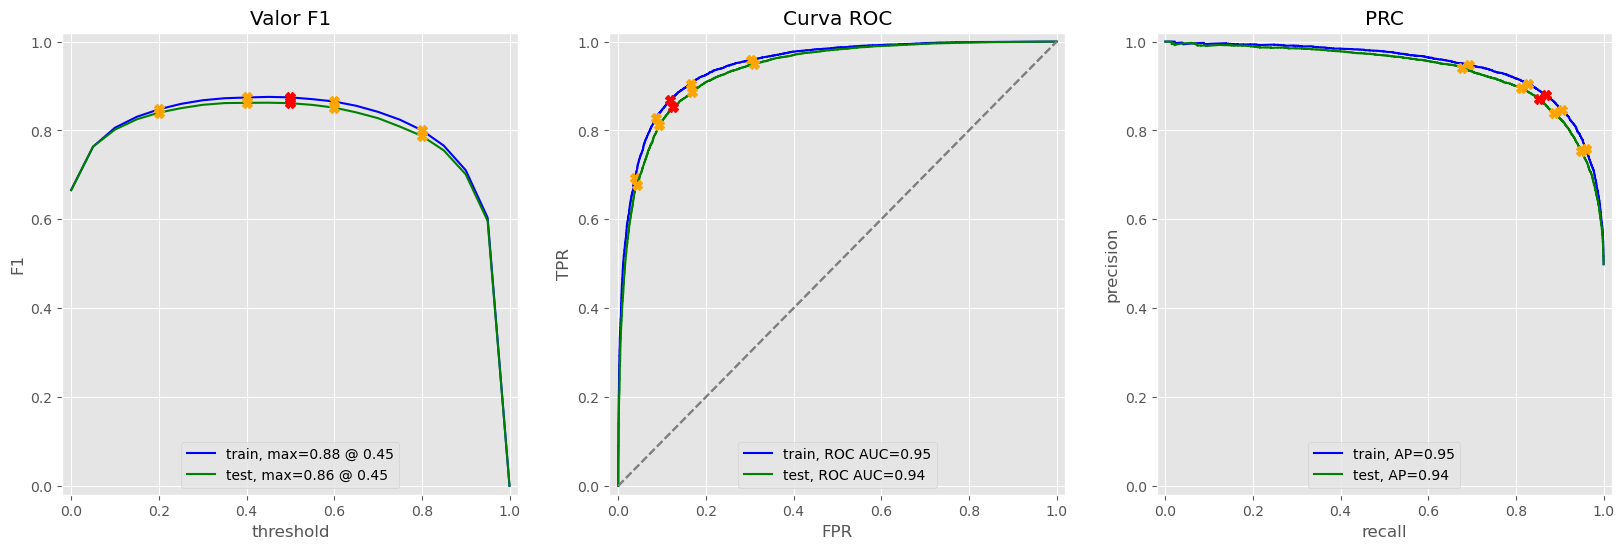

In [37]:
# Evaluar el modelo
evaluate_model(model_9, train_features_9, train_target, test_features_9, test_target)

## Mis reseñas

In [38]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)# <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>


### Modelo 2

In [41]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.17:  well i was bored and felt asleep in the middle of the movie
0.57:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didnt expect the reboot to be so good writers really cared about the source material
0.48:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 3

In [42]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.27:  i didnt expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 4

In [43]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.62:  i did not simply like it not my kind of movie
0.49:  well i was bored and felt asleep in the middle of the movie
0.62:  i was really fascinated with the movie
0.37:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.67:  i didnt expect the reboot to be so good writers really cared about the source material
0.68:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.27:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.78:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 9

In [44]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.39:  i did not simply like it not my kind of movie
0.02:  well i was bored and felt asleep in the middle of the movie
0.99:  i was really fascinated with the movie
0.01:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.08:  i didnt expect the reboot to be so good writers really cared about the source material
0.99:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.02:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.98:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusiones

### Conclusiones del Proyecto

El objetivo principal de este proyecto era desarrollar un modelo capaz de detectar automáticamente reseñas negativas de películas, utilizando el conjunto de datos de reseñas de IMDB. Se probaron múltiples enfoques y modelos, cada uno con sus propias ventajas y limitaciones. A continuación, se resumen los hallazgos más relevantes:

1. **Modelo Constante (DummyClassifier)**:
   - Este modelo fue usado como línea base. Clasifica todas las reseñas como positivas o negativas de acuerdo con la clase más frecuente en los datos de entrenamiento. 
   - Resultados: El F1-score fue 0.0, lo cual es esperable dado que el modelo no intenta predecir correctamente las reseñas negativas. Sirvió como una base para comparar los demás modelos.

2. **Modelo basado en TF-IDF con NLTK y Regresión Logística (Modelo 1)**:
   - Se utilizó una vectorización TF-IDF de las reseñas después de la eliminación de palabras vacías (stopwords) usando NLTK.
   - Resultados: El modelo logró un F1-score de 0.88 en el conjunto de prueba, superando significativamente el modelo constante, con una precisión en la curva ROC-AUC de 0.95, lo que indica que la separación entre reseñas positivas y negativas fue adecuada.

3. **Modelo basado en spaCy, TF-IDF y Regresión Logística (Modelo 3)**:
   - Este modelo incluyó procesamiento adicional con lematización utilizando spaCy antes de aplicar TF-IDF.
   - Resultados: Aunque el proceso de lematización mejoró la precisión en los textos, el F1-score y ROC-AUC fueron similares al Modelo 1, con un F1 de 0.88 y un ROC AUC de 0.95, mostrando que la lematización no proporcionó una mejora significativa.

4. **Modelo basado en spaCy, TF-IDF y LightGBM (Modelo 4)**:
   - Se implementó un clasificador LightGBM utilizando las mismas características que el Modelo 3.
   - Resultados: Este modelo mostró un rendimiento ligeramente inferior en comparación con la regresión logística, con un F1-score de 0.86 en el conjunto de prueba. Aunque LightGBM es un modelo potente, en este caso específico, no superó significativamente a la regresión logística.

5. **Modelo basado en BERT (Modelo 9)**:
   - BERT se utilizó para obtener embeddings contextuales de las reseñas, que luego fueron alimentados a un modelo de regresión logística.
   - Resultados: BERT proporcionó una mejora notable en las reseñas más complejas y contextuales. El F1-score fue de 0.86 en el conjunto de prueba, y alcanzó un AUC de 0.94. Sin embargo, el tiempo de procesamiento fue considerablemente mayor en comparación con otros modelos.

### Consideraciones Finales
- **Tiempo de Procesamiento**: Uno de los mayores retos encontrados fue el tiempo de procesamiento, especialmente al usar BERT. Si bien BERT mostró mejoras en algunas predicciones, su coste computacional podría no ser justificable para implementaciones en tiempo real sin optimizaciones adicionales.
- **Modelos Balanceados**: Los modelos basados en TF-IDF con regresión logística demostraron ser eficientes y alcanzaron métricas competitivas con menor complejidad computacional.
- **F1-Score**: Se cumplió con el objetivo del proyecto al superar el umbral de 0.85 de F1-score en varios modelos, lo que significa que se pueden identificar las reseñas negativas con un alto grado de precisión.
